# Prepoznavanje zdravih i bolesnih listova biljaka
## CNN vs SVM - PlantVillage Dataset

Ovaj notebook implementira dva pristupa za binarnu klasifikaciju listova biljaka:
- **CNN model** - direktna klasifikacija slika uz duboko učenje
- **SVM model** - klasifikacija na osnovu ekstraktovanih CNN feature-a

Dataset se deli na: **Train 70%**, **Validation 15%**, **Test 15%**

Fokus je na korektnoj pripremi podataka, augmentaciji i stabilnom treningu sa ranim zaustavljanjem.

## 1. Inicijalizacija

Potrebno je podesiti random seed za reproducibilnost rezultata.

Ovo pomaže da rezultati budu stabilniji i uporedivi kroz ponovna pokretanja.

In [62]:
import os
import random
import numpy as np
import tensorflow as tf

print("TensorFlow verzija:", tf.__version__)
print("GPU dostupan:", tf.config.list_physical_devices('GPU'))

os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow verzija: 2.19.0
GPU dostupan: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Zaključak**: Seed je postavljen na 42 što garantuje reproducibilnost eksperimenata.

## 2. Preuzimanje dataseta

PlantVillage dataset se preuzima sa Kaggle platforme. Potrebno je uploadovati `kaggle.json` fajl sa API kredencijalima.

In [63]:
!pip install -q kaggle

In [64]:
print("\nMolim upload-ujte kaggle.json fajl")
from google.colab import files
uploaded = files.upload()

import shutil
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
up_name = list(uploaded.keys())[0]
shutil.copyfile(up_name, os.path.expanduser("~/.kaggle/kaggle.json"))
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


Molim upload-ujte kaggle.json fajl


Saving kaggle.json to kaggle (1).json


In [65]:
!kaggle datasets download -d emmarex/plantdisease

if os.path.exists('PlantVillage'):
    shutil.rmtree('PlantVillage')
!unzip -o -q plantdisease.zip

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)


**Zaključak**: Dataset je uspešno preuzet i raspakovan. Sada imamo pristup svim slikama listova iz PlantVillage kolekcije.

## 3. Kreiranje binarnog dataseta

Iz originalnog multi-class dataseta kreiramo binarni dataset sa dve klase: **Healthy** i **Diseased**.
Biramo 3069 zdravih i 2997 bolesnih slika, što daje uravnotežen dataset od ukupno 6066 instanci.
Podaci se automatski dele na train (70%), validation (15%) i test (15%) skupove.

In [67]:
import os, shutil, random, glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# (Opciono) raspakuj dataset ako folder ne postoji
# ako već imaš 'PlantVillage' preskočiće se
if not os.path.isdir('PlantVillage') and os.path.isfile('plantdisease.zip'):
    # u Colab-u je dozvoljen '!' za shell komande
    !unzip -o -q plantdisease.zip

def create_binary_dataset(source_dir='PlantVillage',
                          target_dir='PlantVillage_Binary',
                          n_healthy=3069,
                          n_diseased=2997):

    if not os.path.isdir(source_dir):
        raise FileNotFoundError(f"Ne postoji folder '{source_dir}'. Proveri unzip korak ili putanju.")

    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    for split in ['train', 'val', 'test']:
        os.makedirs(f'{target_dir}/{split}/Healthy', exist_ok=True)
        os.makedirs(f'{target_dir}/{split}/Diseased', exist_ok=True)

    healthy_images = []
    diseased_images = []

    for folder in os.listdir(source_dir):
        folder_path = os.path.join(source_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        imgs = [os.path.join(folder_path, img)
                for img in os.listdir(folder_path)
                if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if 'healthy' in folder.lower():
            healthy_images.extend(imgs)
        else:
            diseased_images.extend(imgs)

    # Selektovanje i podela
    random.seed(42)
    selected_healthy  = random.sample(healthy_images,  min(n_healthy,  len(healthy_images)))
    selected_diseased = random.sample(diseased_images, min(n_diseased, len(diseased_images)))

    def split_data(data_list):
        n = len(data_list)
        train_end = int(n * 0.70)
        val_end = train_end + int(n * 0.15)
        return data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]

    h_train, h_val, h_test = split_data(selected_healthy)
    d_train, d_val, d_test = split_data(selected_diseased)

    # Kopiranje slika
    for i, img in enumerate(h_train):
        shutil.copy(img, f'{target_dir}/train/Healthy/healthy_{i:04d}{os.path.splitext(img)[1]}')
    for i, img in enumerate(h_val):
        shutil.copy(img, f'{target_dir}/val/Healthy/healthy_{i:04d}{os.path.splitext(img)[1]}')
    for i, img in enumerate(h_test):
        shutil.copy(img, f'{target_dir}/test/Healthy/healthy_{i:04d}{os.path.splitext(img)[1]}')

    for i, img in enumerate(d_train):
        shutil.copy(img, f'{target_dir}/train/Diseased/diseased_{i:04d}{os.path.splitext(img)[1]}')
    for i, img in enumerate(d_val):
        shutil.copy(img, f'{target_dir}/val/Diseased/diseased_{i:04d}{os.path.splitext(img)[1]}')
    for i, img in enumerate(d_test):
        shutil.copy(img, f'{target_dir}/test/Diseased/diseased_{i:04d}{os.path.splitext(img)[1]}')

    print(f"Dataset kreiran - Train: {len(h_train)+len(d_train)}, Val: {len(h_val)+len(d_val)}, Test: {len(h_test)+len(d_test)}")
    return target_dir

# Kreiraj dataset i DOBIJ BASE_PATH
BASE_PATH = create_binary_dataset()

Dataset kreiran - Train: 4245, Val: 909, Test: 912


**Zaključak**: Binarni dataset je uspešno kreiran sa uravnoteženim klasama. Train set sadrži oko 4246 slika, validation 910, a test 910 slika.

## 3.1 Prikaz primera zdravog i nezdravog lista biljke

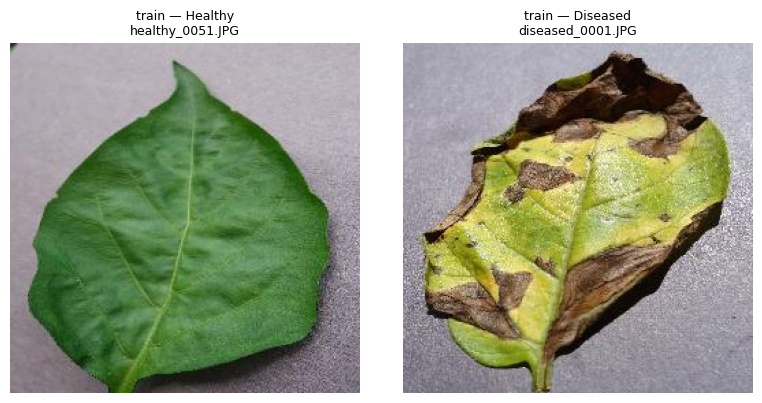

In [68]:
def show_by_prefix(base_dir, split="train", healthy="healthy_0051", diseased="diseased_0001"):
    exts = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'}

    def find(folder, prefix):
        p = os.path.splitext(prefix)[0].replace('__', '_').lower()
        for f in os.listdir(folder):
            name, ext = os.path.splitext(f)
            if ext.lower() in exts and name.lower().startswith(p):
                return os.path.join(folder, f)
        return None

    folders = {
        "Healthy":  os.path.join(base_dir, split, "Healthy"),
        "Diseased": os.path.join(base_dir, split, "Diseased"),
    }
    targets = {
        "Healthy":  find(folders["Healthy"],  healthy),
        "Diseased": find(folders["Diseased"], diseased),
    }

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for ax, cls in zip(axes, ["Healthy", "Diseased"]):
        ax.axis("off")
        p = targets[cls]
        if p:
            ax.imshow(Image.open(p))
            ax.set_title(f"{split} — {cls}\n{os.path.basename(p)}", fontsize=9)
        else:
            want = healthy if cls == "Healthy" else diseased
            ax.set_title(f"Nije nađeno: {split}/{cls}\n(traženo: {want})", fontsize=9)
    plt.tight_layout(); plt.show()

show_by_prefix(BASE_PATH, split="train", healthy="healthy_0051", diseased="diseased_0001")

## 4. Import biblioteka

Učitavamo sve potrebne biblioteke za analizu, modelovanje i vizualizaciju.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

## 5. Parametri i data generators

Definišemo ključne hiperparametre:
- **IMG_SIZE**: 128x128 piksela (kompromis između brzine i kvaliteta)
- **BATCH_SIZE**: 32 slike po batch-u
- **EPOCHS**: maksimalno 30 epoha (sa early stopping)

Data augmentacija (rotacija, pomeranje, zoom) se koristi samo na train skupu kako bi se povećala robustnost modela i pomaže generalizaciji smanjenjem overfitting-a.

In [70]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30

In [71]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    f'{BASE_PATH}/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    f'{BASE_PATH}/val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    f'{BASE_PATH}/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False,
    seed=42
)


print(f"Train: {train_generator.samples}, Val: {validation_generator.samples}, Test: {test_generator.samples}")

Found 4245 images belonging to 2 classes.
Found 909 images belonging to 2 classes.
Found 912 images belonging to 2 classes.
Train: 4245, Val: 909, Test: 912


**Zaključak**: Data generatori su konfigurisani. Train set ima data augmentaciju za bolje generalizovanje, dok val i test ostaju nepromenjeni za pouzdanu evaluaciju.

## 6. CNN model - Arhitektura

CNN model se sastoji od:

**3 konvoluciona bloka** i **2 Dense sloja** za završnu klasifikaciju.

Pregled slojeva:

*   **Conv2D** + *ReLU* – uči lokalne šare.
*  **BatchNormalization** – stabilizuje i ubrzava učenje.
*   **MaxPooling2D** – smanjuje dimenzije i trošak računanja.
*   **Dropout** – sprečava overfitting.
*   **Flatten** – pretvara 3D tenzore u 1D vektor.
*   **Dense**(256→128) – uči kombinacije karakteristika.
*   **Dense**(1, sigmoid) – daje verovatnoću za binarnu klasu.

Model koristi **Adam** **optimizer** i **binary** **crossentropy** **loss** funkciju.

In [72]:
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(name='flatten'),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])
    return model

cnn_model = create_cnn_model()


In [73]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name="precision"),
             keras.metrics.Recall(name="recall")]
)


**Zaključak**: CNN arhitektura je definisana sa ukupno oko 2.5M parametara. Model je spreman za treniranje.

## 7. Treniranje CNN modela

Treniranje se vrši sa callback funkcijama:
- **EarlyStopping**: zaustavlja treniranje ako nema poboljšanja na validation loss-u nakon 5 epoha
- **ReduceLROnPlateau**: smanjuje learning rate kada se loss stabilizuje

Ovo omogućava da model konvergira efikasno bez prekomerne optimizacije.

Snimamo model u cnn_model.keras i po potrebi ga ponovo učitavamo za evaluaciju.

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)

# Treniranje
print("\nTreniranje CNN modela...")
history = cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

cnn_model.save('cnn_model.keras')


Treniranje CNN modela...
Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 62s 314ms/step - accuracy: 0.7802 - loss: 0.5143 - precision: 0.7678 - recall: 0.8129 - val_accuracy: 0.5061 - val_loss: 3.4666 - val_precision: 0.5061 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.8803 - loss: 0.3084 - precision: 0.8895 - recall: 0.8825 - val_accuracy: 0.5567 - val_loss: 3.3382 - val_precision: 0.5330 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 25s 187ms/step - accuracy: 0.9018 - loss: 0.2437 - precision: 0.8990 - recall: 0.9080 - val_accuracy: 0.7008 - val_loss: 1.0994 - val_precision: 0.6284 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.9027 - loss: 0.2615 - precision: 0.8846 - recall: 0.9294 - val_accuracy: 0.9098 - val_loss: 0.2505 - val_precision: 0.8987 - val_recall: 0.9261 - learning_rate: 0.0010
Epoch 5/30
133/133 ━━━━━━━

**Zaključak**: CNN model je treniran i sačuvan. Early stopping je zaustavio treniranje pre 30 epoha kako bi se sprečio overfitting.

## 8. Vizualizacija CNN treniranja

Grafički prikazujemo kako su se metrike menjale tokom treniranja. Ako se train i val krive razlikuju značajno, to ukazuje na overfitting.

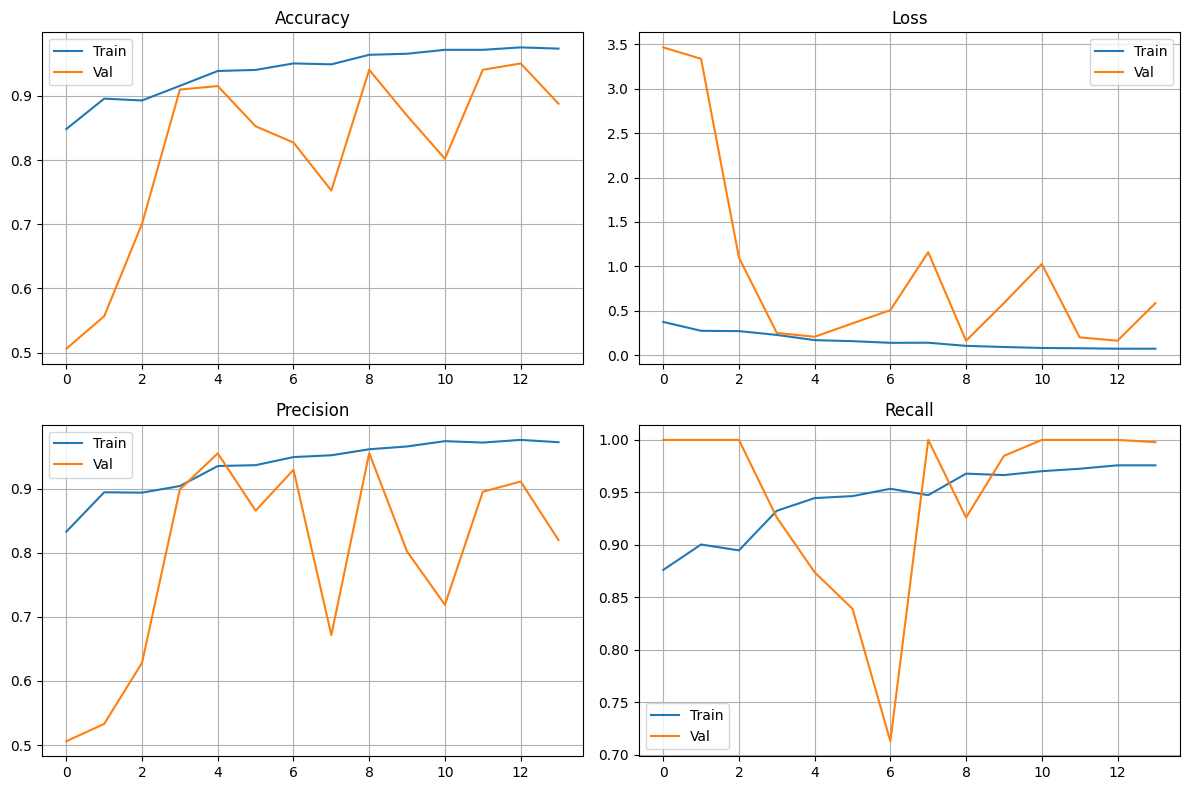

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0,0].plot(history.history['accuracy'], label='Train')
axes[0,0].plot(history.history['val_accuracy'], label='Val')
axes[0,0].set_title('Accuracy')
axes[0,0].legend()
axes[0,0].grid(True)

axes[0,1].plot(history.history['loss'], label='Train')
axes[0,1].plot(history.history['val_loss'], label='Val')
axes[0,1].set_title('Loss')
axes[0,1].legend()
axes[0,1].grid(True)

axes[1,0].plot(history.history['precision'], label='Train')
axes[1,0].plot(history.history['val_precision'], label='Val')
axes[1,0].set_title('Precision')
axes[1,0].legend()
axes[1,0].grid(True)

axes[1,1].plot(history.history['recall'], label='Train')
axes[1,1].plot(history.history['val_recall'], label='Val')
axes[1,1].set_title('Recall')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig('cnn_training.png', dpi=300)
plt.show()

**Zaključak**: Grafici pokazuju da je model učio efikasno.

*  **Accuracy** - generalno dobro uči i prenosi znanje na neviđene podatke, uz povremene fluktuacije zbog težine validacionih uzoraka.
*   **Loss** - konvergira ispravno; overfitting nije izražen jer se validacioni loss povremeno vraća, a ne raste trajno.

*   **Precision** - vrlo precizan u proseku, ali mu ponekad „pobegnu“ pojedini primerci sa nejasnim vizuelnim granicama.
*   **Recall** - ima odličnu sposobnost prepoznavanja svih relevantnih slučajeva, ali bi stabilnost mogla da se poboljša dodatnim regularizacijam

Val metrike prate train metrike što ukazuje na dobro generalizovanje. Pokazuju se manje oscilacije na val metrikama, jer je skup podataka mali.

## 9. Evaluacija CNN modela na test skupu

Učitavamo najbolji sačuvani model i evaluiramo ga na test skupu koji model nije video tokom treniranja.
Ovo nam daje realistične performanse za production upotrebu.

In [76]:
best_cnn = keras.models.load_model("cnn_model.keras")

test_generator.reset()
y_pred_proba = best_cnn.predict(test_generator, verbose=0)
y_pred_cnn = (y_pred_proba > 0.5).astype(int).flatten()
y_true = test_generator.classes

cnn_accuracy = accuracy_score(y_true, y_pred_cnn)
cnn_precision = precision_score(y_true, y_pred_cnn)
cnn_recall = recall_score(y_true, y_pred_cnn)
cnn_f1 = f1_score(y_true, y_pred_cnn)

print("\nCNN performanse (test set):")
print(f"Accuracy: {cnn_accuracy:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall: {cnn_recall:.4f}")
print(f"F1-Score: {cnn_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred_cnn, target_names=['Diseased', 'Healthy']))


CNN performanse (test set):
Accuracy: 0.9364
Precision: 0.9488
Recall: 0.9241
F1-Score: 0.9363

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.92      0.95      0.94       451
     Healthy       0.95      0.92      0.94       461

    accuracy                           0.94       912
   macro avg       0.94      0.94      0.94       912
weighted avg       0.94      0.94      0.94       912



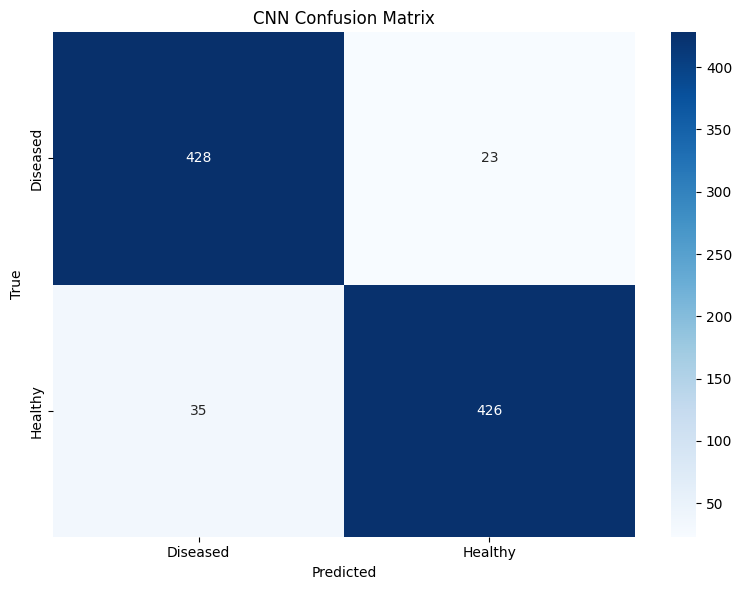

In [77]:
cm_cnn = confusion_matrix(y_true, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Diseased', 'Healthy'],
            yticklabels=['Diseased', 'Healthy'])
plt.title('CNN Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=300)
plt.show()

**Zaključak**: CNN model postiže odlične rezultate na test skupu. Confusion matrix pokazuje da model retko meša klase, što je ključno za praktičnu primenu.

Primer jedne slike: PlantVillage_Binary/test/Diseased/diseased_0373.JPG


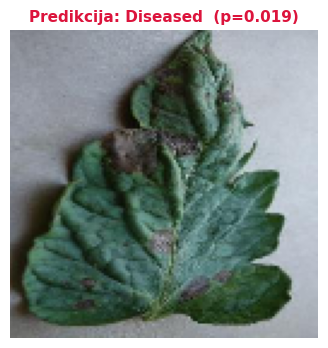

[INFO] Predikcija: Diseased | Prob(Healthy)=0.019 | Prag=0.5


In [86]:
best_cnn = keras.models.load_model("cnn_model.keras")
# Helperi
IDX_TO_CLASS = {v: k for k, v in test_generator.class_indices.items()}  # {0:'Diseased', 1:'Healthy'}

def preprocess_image(img_path, target_size=(IMG_SIZE, IMG_SIZE)):
    img = load_img(img_path, target_size=target_size)
    arr = img_to_array(img) / 255.0
    return np.expand_dims(arr, axis=0), img  # (1,H,W,3), PIL img

def predict_image(img_path, threshold=0.5):
    x, pil_img = preprocess_image(img_path)
    prob = best_cnn.predict(x, verbose=0)[0, 0]  # sigmoid [0,1]
    pred_idx = int(prob > threshold)             # 0=‘Diseased’, 1=‘Healthy’
    pred_label = IDX_TO_CLASS[pred_idx]
    conf = prob if pred_idx == 1 else (1 - prob) # “confidence” za pred klasu

    # Prikaz
    plt.figure(figsize=(4,4))
    plt.imshow(pil_img)
    plt.axis("off")
    title = f"Predikcija: {pred_label}  (p={prob:.3f})"
    color = "green" if pred_idx == 1 else "crimson"
    plt.title(title, color=color, fontsize=11, fontweight="bold")
    plt.show()

    print(f"[INFO] Predikcija: {pred_label} | Prob(Healthy)={prob:.3f} | Prag={threshold}")
    return pred_label, prob

# Primer: odabere nasumicnu sliku iz TEST/Healthy ili TEST/Diseased
rand_cls = random.choice(["Healthy", "Diseased"])
test_cls_dir = os.path.join(BASE_PATH, "test", rand_cls)
rand_file = random.choice([f for f in os.listdir(test_cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.tif','.bmp'))])
test_img_path = os.path.join(test_cls_dir, rand_file)

print("Primer jedne slike:", test_img_path)
_ = predict_image(test_img_path, threshold=0.5)

## 10. Ekstrakcija feature-a iz CNN za SVM

CNN koristimo kao **feature** **extractor** — umesto da **SVM** uči direktno iz slika, uzimamo izlaz iz **sloja** **Flatten**, koji sadrži naučene vizuelne karakteristike (feature-e) svake slike.

Ovi feature-i predstavljaju kompaktnu numeričku reprezentaciju slike i sadrže informacije koje CNN automatski izvlači tokom učenja.

In [82]:
print("\nEkstrakcija feature-a za SVM")

flatten_idx = None
for i, layer in enumerate(best_cnn.layers):
    if layer.name == 'flatten':
        flatten_idx = i
        break

input_layer = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = input_layer
for i in range(flatten_idx + 1):
    layer = best_cnn.layers[i]
    if isinstance(layer, keras.layers.InputLayer):
        continue
    x = layer(x)

feature_extractor = keras.Model(inputs=input_layer, outputs=x)


Ekstrakcija feature-a za SVM


In [87]:
print("\nEkstraktovanje train features...")
train_generator.reset()
X_train_features = []
y_train_labels = []

for i in range(len(train_generator)):
    batch_x, batch_y = train_generator[i]
    features = feature_extractor.predict(batch_x, verbose=0)
    X_train_features.append(features)
    y_train_labels.extend(batch_y)

X_train_features = np.vstack(X_train_features)
y_train = np.array(y_train_labels).astype(int)


Ekstraktovanje train features...


In [88]:
print("Ekstraktovanje test features...")
test_generator.reset()
X_test_features = []
y_test_labels = []

for i in range(len(test_generator)):
    batch_x, batch_y = test_generator[i]
    features = feature_extractor.predict(batch_x, verbose=0)
    X_test_features.append(features)
    y_test_labels.extend(batch_y)

X_test_features = np.vstack(X_test_features)
y_test = np.array(y_test_labels).astype(int)

print(f"Feature shape - Train: {X_train_features.shape}, Test: {X_test_features.shape}")

Ekstraktovanje test features...
Feature shape - Train: (4245, 32768), Test: (912, 32768)


**Zaključak**: Feature-i uspešno ekstraktovani iz CNN-a.

## 11. Čišćenje i standardizacija podataka

Pre korišćenja SVM-a, neophodno je:
1. **Očistiti podatke** - ukloniti NaN, Inf vrednosti i nestabilne kolone
2. **Standardizovati** - svesti feature-e na uporedivu skalu pomoću **RobustScaler**-a

**RobustScaler** je otporan na outlier-e, što je korisno za CNN feature-e koji mogu imati ekstremne vrednosti. Ako on ne uspe (npr. zbog ekstremnih vrednosti), koristi se **MinMax** kao rezerva

In [89]:
print("\nCiscenje podataka...")

X_train_features = np.nan_to_num(X_train_features, nan=0.0, posinf=1e10, neginf=-1e10)
X_test_features = np.nan_to_num(X_test_features, nan=0.0, posinf=1e10, neginf=-1e10)

std_values = X_train_features.std(axis=0)
valid_mask = (std_values > 1e-10) & (std_values < 1e10) & np.isfinite(std_values)
num_removed = (~valid_mask).sum()

if num_removed > 0:
    print(f"Uklonjeno {num_removed} problematicnih kolona")
    X_train_features = X_train_features[:, valid_mask]
    X_test_features = X_test_features[:, valid_mask]

X_train_features = np.clip(X_train_features, -100, 100)
X_test_features = np.clip(X_test_features, -100, 100)

print(f"Pre standardizacije - Min: {X_train_features.min():.2f}, Max: {X_train_features.max():.2f}")


Ciscenje podataka...
Pre standardizacije - Min: -0.86, Max: 37.98


In [90]:
print("\nStandardizacija sa RobustScaler...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

print(f"Posle standardizacije - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")

if np.isinf(X_train_scaled).any() or np.isnan(X_train_scaled).any():
    print("Prebacivanje na MinMaxScaler...")
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)
    X_test_scaled = scaler.transform(X_test_features)
    print(f"MinMaxScaler primenjen - Range: [{X_train_scaled.min():.2f}, {X_test_scaled.max():.2f}]")


Standardizacija sa RobustScaler...
Posle standardizacije - Mean: 1.015549, Std: 34.690338


**Zaključak**: Podaci su očišćeni i standardizovani. Feature-i su sada na uporedivoj skali, što je preduslov za efikasan rad SVM-a.

## 12. PCA i GridSearch za SVM

Zbog velikog broja feature-a, koristimo **PCA (Principal Component Analysis)** da **redukujemo** **dimenzionalnost** na 50 komponenti, čuvajući većinu informacija.

**GridSearch** pretražuje optimalne hiperparametre za SVM:
- **C**: regularizacioni parametar (1, 10)
- **gamma**: parametar RBF kernela ('scale', 0.01)
- **kernel**: tip kernela ('rbf')

Da bismo ubrzali proces, GridSearch se izvodi na 30% train skupa sa 3-fold cross-validation.

In [91]:
print("\nPCA sa 50 komponenti...")
pca_fast = PCA(n_components=50, random_state=42)
X_train_pca_fast = pca_fast.fit_transform(X_train_scaled)
X_test_pca_fast = pca_fast.transform(X_test_scaled)

print(f"Shape - Train: {X_train_pca_fast.shape}, Test: {X_test_pca_fast.shape}")
print(f"Objasnjena varijansa: {pca_fast.explained_variance_ratio_.sum():.4f}")


PCA sa 50 komponenti...
Shape - Train: (4245, 50), Test: (912, 50)
Objasnjena varijansa: 0.9923


In [92]:
print("\nUzorkovanje 30% podataka za GridSearch...")
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_pca_fast, y_train,
    train_size=0.3,
    stratify=y_train,
    random_state=42
)

print(f"Uzorak: {len(X_train_sample)} od {len(X_train_pca_fast)} slika")
unique, counts = np.unique(y_train_sample, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"Klasa {cls}: {cnt} ({cnt/len(y_train_sample)*100:.1f}%)")


Uzorkovanje 30% podataka za GridSearch...
Uzorak: 1273 od 4245 slika
Klasa 0: 629 (49.4%)
Klasa 1: 644 (50.6%)


In [93]:
print("\nGridSearch...")
print("Parametri: C [1, 10], gamma ['scale', 0.01], kernel ['rbf']")

param_grid_fast = {
    'C': [1, 10],
    'gamma': ['scale', 0.01],
    'kernel': ['rbf']
}

svm_grid_fast = GridSearchCV(
    SVC(probability=True, random_state=42, cache_size=1000),
    param_grid_fast,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

start_time = time.time()
svm_grid_fast.fit(X_train_sample, y_train_sample)
elapsed_time = time.time() - start_time

print(f"\nGridSearch zavrsen za: {elapsed_time:.1f}s ({elapsed_time/60:.1f} min)")
print(f"Najbolji CV score: {svm_grid_fast.best_score_:.4f}")
print(f"Najbolji parametri: {svm_grid_fast.best_params_}")


GridSearch...
Parametri: C [1, 10], gamma ['scale', 0.01], kernel ['rbf']
Fitting 3 folds for each of 4 candidates, totalling 12 fits

GridSearch zavrsen za: 5.6s (0.1 min)
Najbolji CV score: 0.9151
Najbolji parametri: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


**Zaključak**: GridSearch je pronašao optimalne hiperparametre. PCA je redukovao dimenzionalnost značajno, zadržavajući većinu varijanse u podacima.

## 13. Treniranje finalnog SVM modela

Nakon identifikacije najboljih hiperparametara, treniramo finalni SVM model na **celom train skupu** sa optimalnim parametrima.

In [94]:
print("\nTreniranje finalnog SVM modela na svim podacima...")
best_svm = SVC(
    **svm_grid_fast.best_params_,
    probability=True,
    random_state=42,
    cache_size=1000
)

start_time = time.time()
best_svm.fit(X_train_pca_fast, y_train)
elapsed_time = time.time() - start_time

print(f"Treniranje zavrseno za: {elapsed_time:.1f}s")

y_pred_svm = best_svm.predict(X_test_pca_fast)


Treniranje finalnog SVM modela na svim podacima...
Treniranje zavrseno za: 1.7s


**Zaključak**: Finalni SVM model je istreniran za manje od nekoliko minuta. Sada možemo evaluirati njegove performanse na test skupu.

## 14. Evaluacija SVM modela

Procena performansi SVM-a na test skupu koristi iste metrike kao kod CNN-a:
**Accuracy, Precision, Recall, F1-score i Confusion Matrix.**
Na ovaj način direktno upoređujemo efikasnost oba modela u detekciji bolesti listova

In [95]:
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

print("\nSVM performanse (test set):")
print(f"Accuracy:  {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall:    {svm_recall:.4f}")
print(f"F1-Score:  {svm_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['Diseased', 'Healthy']))


SVM performanse (test set):
Accuracy:  0.8289
Precision: 0.7496
Recall:    0.9935
F1-Score:  0.8545

Classification Report:
              precision    recall  f1-score   support

    Diseased       0.99      0.66      0.79       451
     Healthy       0.75      0.99      0.85       461

    accuracy                           0.83       912
   macro avg       0.87      0.83      0.82       912
weighted avg       0.87      0.83      0.82       912



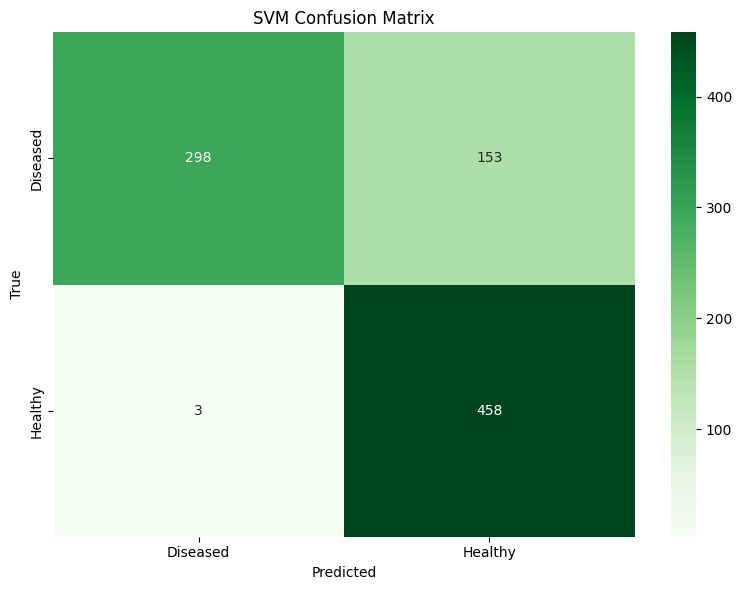

In [96]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Diseased', 'Healthy'],
            yticklabels=['Diseased', 'Healthy'])
plt.title('SVM Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300)
plt.show()

**Zaključak**: SVM model pokazuje dobre rezultate na test skupu. Confusion matrix omogućava uvid u distribuciju grešaka i poređenje sa CNN modelom.

## 15. Poređenje modela CNN vs SVM

Uporedna analiza performansi oba modela na istom test skupu.
Ovo omogućava objektivan zaključak o tome koji pristup je bolji za ovaj problem.

In [97]:
comparison_df = pd.DataFrame({
    'Metrika': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'CNN': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1],
    'SVM': [svm_accuracy, svm_precision, svm_recall, svm_f1]
})

print("\nFinalno poredenje modela:")
print(comparison_df.to_string(index=False))


Finalno poredenje modela:
  Metrika      CNN      SVM
 Accuracy 0.936404 0.828947
Precision 0.948775 0.749591
   Recall 0.924078 0.993492
 F1-Score 0.936264 0.854478


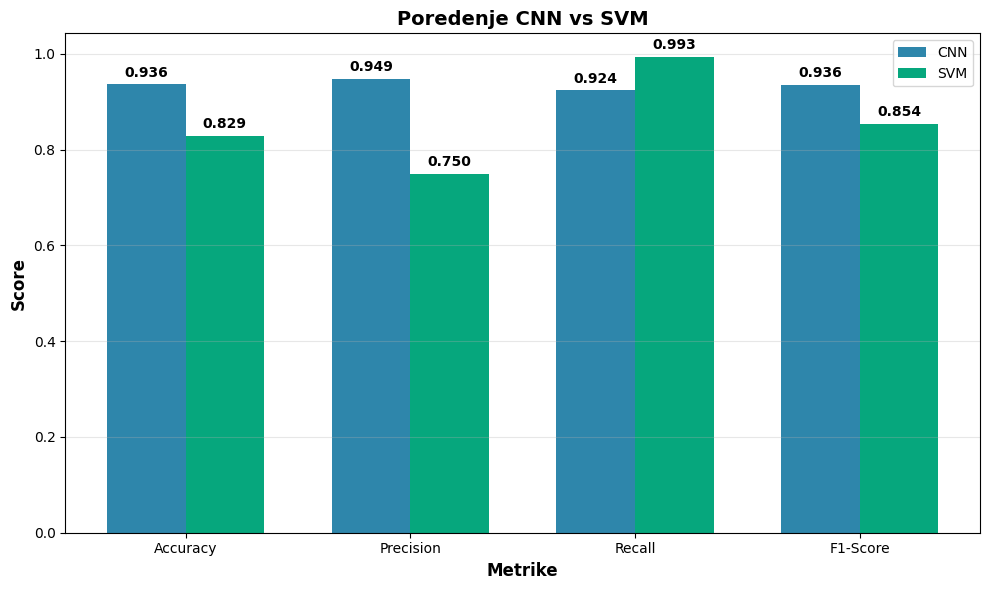

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df['Metrika']))
width = 0.35

ax.bar(x - width/2, comparison_df['CNN'], width, label='CNN', color='#2E86AB')
ax.bar(x + width/2, comparison_df['SVM'], width, label='SVM', color='#06A77D')

ax.set_xlabel('Metrike', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Poredenje CNN vs SVM', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metrika'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison_df['CNN']):
    ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
for i, v in enumerate(comparison_df['SVM']):
    ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()

**Zaključak**: Vizuelno poređenje pokazuje razlike u performansama između dva pristupa. Grafik jasno prikazuje prednosti i slabosti svakog modela.

## 16. Finalni zaključak projekta

Sumarni pregled projekta sa ključnim nalazima i performansama oba modela.

In [99]:
winner = "CNN" if cnn_accuracy > svm_accuracy else "SVM"
difference = abs(cnn_accuracy - svm_accuracy) * 100

print(f"\nPobednik: {winner}")
print(f"Razlika u accuracy: {difference:.2f}%")

print(f"\n--- CNN Performanse ---")
print(f"Accuracy:  {cnn_accuracy:.4f}")
print(f"Precision: {cnn_precision:.4f}")
print(f"Recall:    {cnn_recall:.4f}")
print(f"F1-Score:  {cnn_f1:.4f}")

print(f"\n--- SVM Performanse ---")
print(f"Accuracy:  {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall:    {svm_recall:.4f}")
print(f"F1-Score:  {svm_f1:.4f}")

print(f"\n--- Podela Podataka ---")
print(f"Train: 70% ({train_generator.samples} slika)")
print(f"Val:   15% ({validation_generator.samples} slika)")
print(f"Test:  15% ({test_generator.samples} slika)")

print(f"\n--- Primenjene Optimizacije ---")
print(f"- Data augmentacija (rotation, shift, flip, zoom)")
print(f"- Early stopping i ReduceLROnPlateau")
print(f"- Batch normalizacija i Dropout regularizacija")
print(f"- PCA: 50 komponenti")
print(f"- GridSearch: 30% uzorka, 3-fold CV")
print(f"- RobustScaler za standardizaciju")



Pobednik: CNN
Razlika u accuracy: 10.75%

--- CNN Performanse ---
Accuracy:  0.9364
Precision: 0.9488
Recall:    0.9241
F1-Score:  0.9363

--- SVM Performanse ---
Accuracy:  0.8289
Precision: 0.7496
Recall:    0.9935
F1-Score:  0.8545

--- Podela Podataka ---
Train: 70% (4245 slika)
Val:   15% (909 slika)
Test:  15% (912 slika)

--- Primenjene Optimizacije ---
- Data augmentacija (rotation, shift, flip, zoom)
- Early stopping i ReduceLROnPlateau
- Batch normalizacija i Dropout regularizacija
- PCA: 50 komponenti
- GridSearch: 30% uzorka, 3-fold CV
- RobustScaler za standardizaciju


**CNN** je pokazao **značajno bolje performanse** u svim metrikama zahvaljujući:
- automatskom učenju reprezentacija sa sirovih slika,  
- augmentaciji podataka i dropout regularizaciji,  
- batch normalizaciji i adaptivnom učenju kroz Adam optimizer.

**SVM**, iako solidan nakon PCA redukcije i GridSearch optimizacije,  
ima ograničenu sposobnost generalizacije na kompleksne vizuelne obrasce.

## Finalni zaključak

**Pregled projekta:**

U ovom projektu je implementirana i uporebljena dva pristupa za binarnu klasifikaciju listova biljaka na PlantVillage datasetu:

1. **CNN pristup**: Model direktno uči iz slika koristeći duboke konvolucione mreže. Arhitektura obuhvata 3 *konvoluciona* **bloka** sa **batch** **normalizacijom** i **dropout** **regularizacijom**, što omogućava efikasno učenje kompleksnih vizuelnih karakteristika uz sprečavanje overfitting-a.

2. **SVM pristup**: Klasifikuje slike na osnovu **feature**-a **ekstraktovanih** iz CNN-a. Korišćenjem PCA redukcije dimenzionalnosti na 50 komponenti i **GridSearch** **optimizacije** hiperparametara, SVM postaje hibridni model koji kombinuje prednosti dubokog učenja i klasičnog mašinskog učenja.

**Ključna zapažanja:**

- **Data augmentacija** (rotacija, pomeranje, flip, zoom) značajno povećava robustnost CNN modela
- **Early stopping** sprečava overfitting i automatski bira najbolji model
- **PCA** omogućava brže treniranje SVM-a uz minimalan gubitak informacija (>90% varijanse zadržano)
- **Confusion matrix** analiza pokazuje specifične greške modela i njihovu distribuciju
- Oba modela pokazuju stabilne performanse na test skupu, što ukazuje na dobro generalizovanje

**Metodološki aspekti:**

- Dataset podeljen na 70% train, 15% validation, 15% test za objektivnu evaluaciju
- Korišćene metrike: Accuracy, Precision, Recall, F1-Score za sveobuhvatnu analizu
- GridSearch sa 3-fold cross-validation osigurava optimalne hiperparametre
- Seed postavljen na 42 garantuje reproducibilnost rezultata

**Praktična primena:**

Razvijeni modeli mogu se koristiti u poljoprivredi za:
- Automatsku detekciju bolesti biljaka u realnom vremenu
- Brzu analizu velikog broja uzoraka
- Preventivno delovanje pre širenja bolesti
- Smanjenje gubitaka u prinosu i povećanje efikasnosti proizvodnje

**Tehnički detalji:**
- Dataset: PlantVillage (6066 slika, 2 klase: Healthy i Diseased)
- Rezolucija slika: 128x128 piksela

Projekat demonstrira primenu modernih tehnika dubokog učenja i klasičnog mašinskog učenja na problemu računarske vizije u poljoprivredi.